In [1]:
import cv2
import glob
import pickle
import imageio
import numpy as np
import matplotlib.pyplot as plt

imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from matplotlib.image import imsave

### Config

In [2]:
OUT_PUT_IMAGE_PATTERN = "./output_images/{}.png"

### Image

In [3]:
def load_image_from_address(address):
    image = cv2.imread(address)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Test

In [4]:
def load_test_chess_image():
    return load_image_from_address("camera_cal/test_calibration.jpg")

def load_test_road_image():
    return load_image_from_address("test_images/straight_lines1.jpg")

### Camera Calibration

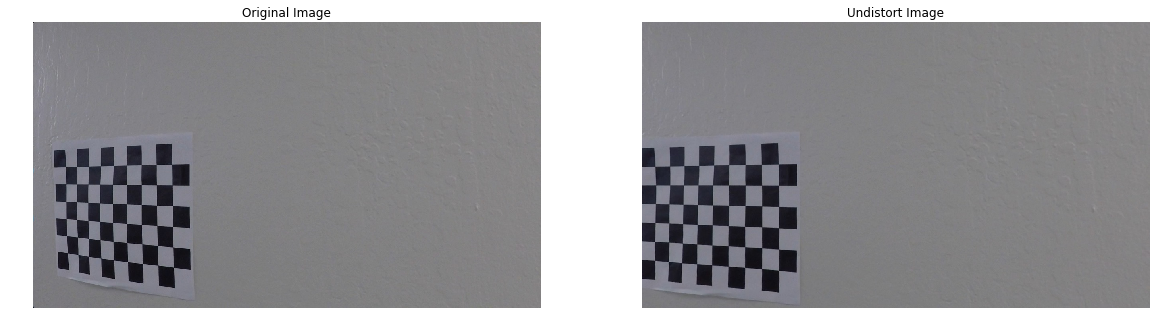

In [5]:
chess_board_points = np.zeros((6 * 9, 3), np.float32)
chess_board_points[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

camera_calibration_image_points = []
camera_calibration_object_points = []

def init_camera_calibration():
    for image_address in glob.glob('camera_cal/cal*.jpg'):
        image = load_image_from_address(image_address)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        ret, chess_corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret == True:
            camera_calibration_image_points.append(chess_corners)
            camera_calibration_object_points.append(chess_board_points)
    
    pickle.dump({'image_point': camera_calibration_image_points, 'object_point': camera_calibration_object_points}, open('camera_calibration.pkl', 'wb'))

def load_camera_calibration():
    
    global camera_calibration_image_points, camera_calibration_object_points
    
    camera_calibration = pickle.load(open('camera_calibration.pkl', 'rb'))
    
    camera_calibration_image_points = camera_calibration['image_point']
    camera_calibration_object_points = camera_calibration['object_point']

def undistort_camera_image(image):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(camera_calibration_object_points, camera_calibration_image_points, (image.shape[1], image.shape[0]), None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)


def test_undistortation():
    
    test_image = load_test_chess_image()
    undistort_image = undistort_camera_image(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(undistort_image.squeeze())
    axs[1].set_title("Undistort Image")
    axs[1].axis('off')
    
    plt.show()

load_camera_calibration()
test_undistortation()

### Prespective transform

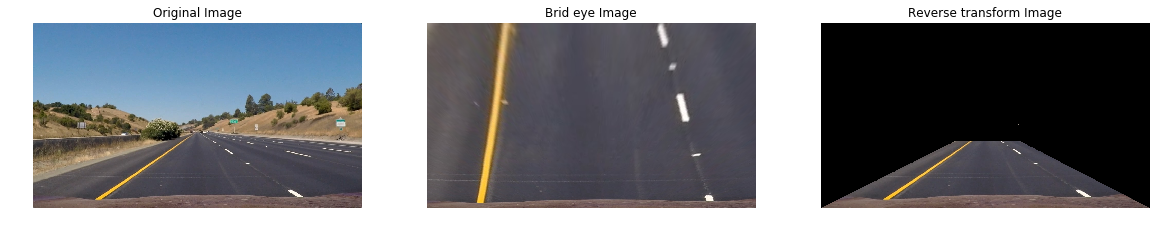

In [6]:
prespective_transform_matrix = None
reverse_prespective_transform_matrix = None

def init_prespective_transform():
    src = np.float32([
        [400,  720],
        [900,  720],
        [600,  460],
        [700,  460]
    ])
    
    dst = np.float32([
        [400,  720],
        [900,  720],
        [400,    0],
        [900,    0] 
    ])
    
    global prespective_transform_matrix, reverse_prespective_transform_matrix
    
    prespective_transform_matrix = cv2.getPerspectiveTransform(src, dst)
    reverse_prespective_transform_matrix = cv2.getPerspectiveTransform(dst, src)
    
    pickle.dump({'matrix': prespective_transform_matrix, "reverse_matrix": reverse_prespective_transform_matrix}, open('prespective_transform.pkl', 'wb'))
    
def load_prespective_tranform():
    global prespective_transform_matrix, reverse_prespective_transform_matrix
    
    prespective_transform = pickle.load(open('prespective_transform.pkl', 'rb'))
    
    try:
        prespective_transform_matrix = prespective_transform['matrix']
        reverse_prespective_transform_matrix = prespective_transform['reverse_matrix']
    except:
        init_prespective_transform()

def prespective_transform(image):
    return cv2.warpPerspective(image, prespective_transform_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def reverse_prespective_transform(image):
    return cv2.warpPerspective(image, reverse_prespective_transform_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def test_prespective_transform():
    
    test_image = load_test_road_image()
    transform_image = prespective_transform(test_image)
    reverse_image = reverse_prespective_transform(transform_image)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 30))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze())
    axs[1].set_title("Brid eye Image")
    axs[1].axis('off')
    
    axs[2].imshow(reverse_image.squeeze())
    axs[2].set_title("Reverse transform Image")
    axs[2].axis('off')
    
    plt.show()

load_prespective_tranform()
init_prespective_transform()
test_prespective_transform()

### Sobel tranform

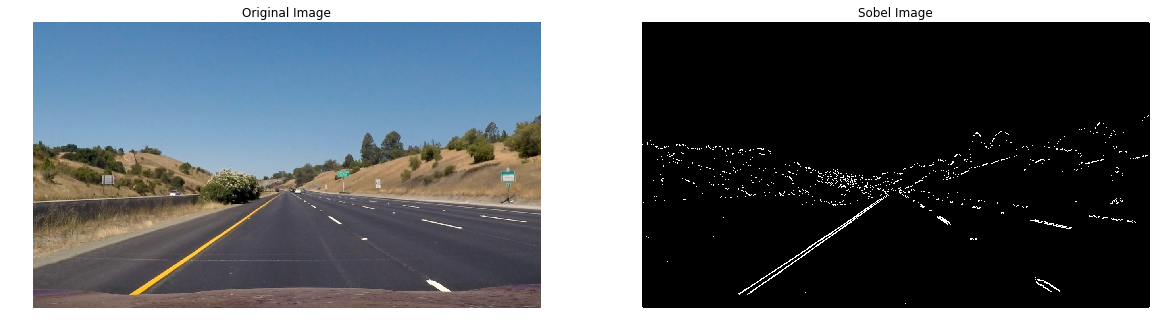

In [7]:
SOBEL_KERNEL_SIZE = 5

def abs_sobel_thresh(image, orient, sobel_kernel=3, thresh=(0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def mag_sobel_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(grad_mag) / 255 
    grad_mag = (grad_mag / scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= thresh[0]) & (grad_mag <= thresh[1])] = 1

    return binary_output

def dir_sobel_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1

    return binary_output


def sobel_transform(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=SOBEL_KERNEL_SIZE, thresh=(20, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=SOBEL_KERNEL_SIZE, thresh=(70, 255))    
    mag_binary = mag_sobel_thresh(gray, sobel_kernel=SOBEL_KERNEL_SIZE, thresh=(50, 255))
    dir_binary = dir_sobel_threshold(gray, sobel_kernel=SOBEL_KERNEL_SIZE, thresh=(0.6, 1.1))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined


def test_sobel_transform():
    
    test_image = load_test_road_image()
    transform_image = sobel_transform(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze(), cmap='gray')
    axs[1].set_title("Sobel Image")
    axs[1].axis('off')
    
    plt.show()

test_sobel_transform()

### Color transform

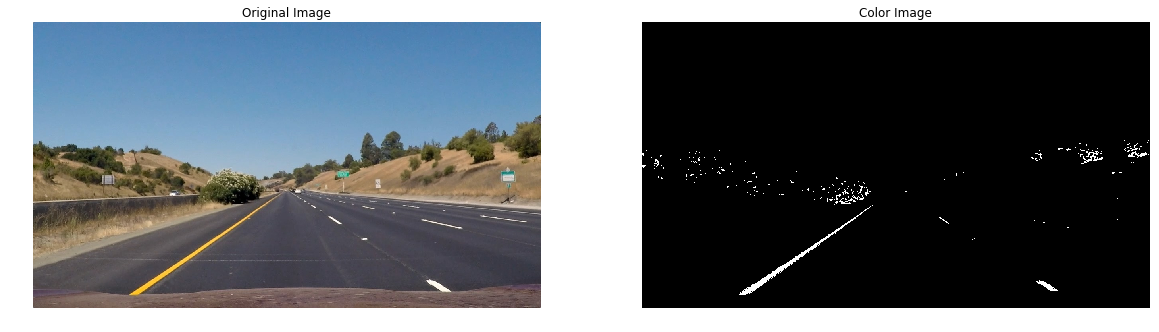

In [8]:
def color_transform_filter(image, thresh=(0, 255)):
    s_channel = image[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def color_transform(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    return color_transform_filter(hls, thresh=(150, 255))

def test_color_transform():
    
    test_image = load_test_road_image()
    transform_image = color_transform(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze(), cmap='gray')
    axs[1].set_title("Color Image")
    axs[1].axis('off')
    
    plt.show()

test_color_transform()

### Threshold transform (Apply both sobel and color thresholding)

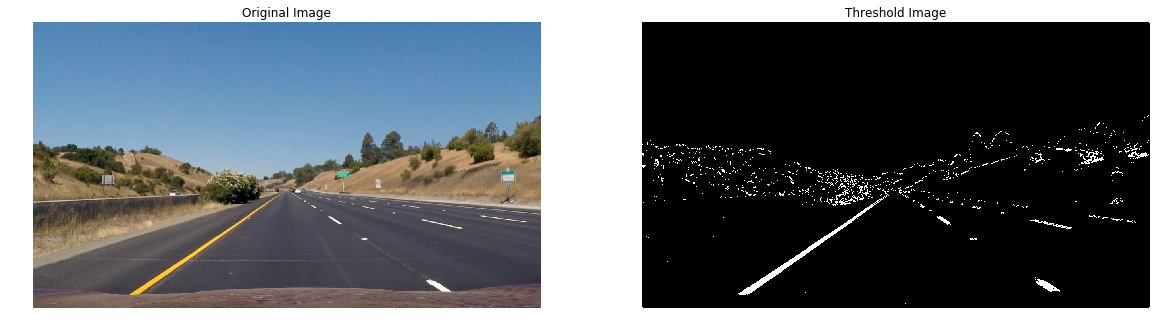

In [9]:
def threshold_transform(image):
    sobel_transform_image = sobel_transform(image)
    color_transform_image = color_transform(image)
    
    combined_binary = np.zeros_like(sobel_transform_image)
    combined_binary[(color_transform_image == 1) | (sobel_transform_image == 1)] = 1
    
    return combined_binary

def test_threshold_transform():
    
    test_image = load_test_road_image()
    transform_image = threshold_transform(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze(), cmap='gray')
    axs[1].set_title("Threshold Image")
    axs[1].axis('off')
    
    plt.show()

test_threshold_transform()

### Region of interest

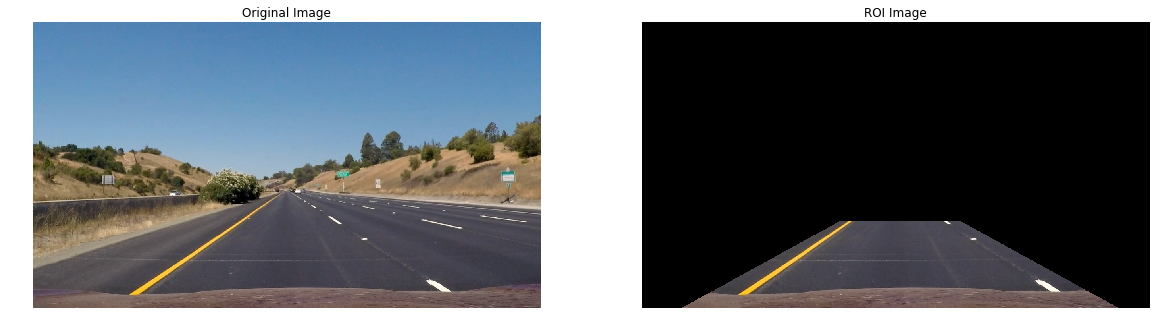

In [10]:
def region_of_interest_transform(image, vertices):
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, (255, ) * image.shape[2] if len(image.shape) > 2 else (255, ))
    return cv2.bitwise_and(image, mask)

def region_of_interest(image):
    
    left_bottom = (100, 720)
    right_bottom = (1200, 720)
    
    left_top = (500, 500)
    right_top = (800, 500)
    
    vertices = np.array([[left_bottom, right_bottom, right_top, left_top]], dtype=np.int32)
    
    return region_of_interest_transform(image, vertices)

def test_region_of_interest():
    
    test_image = load_test_road_image()
    transform_image = region_of_interest(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze())
    axs[1].set_title("ROI Image")
    axs[1].axis('off')
    
    plt.show()

test_region_of_interest()

### Transform pipline

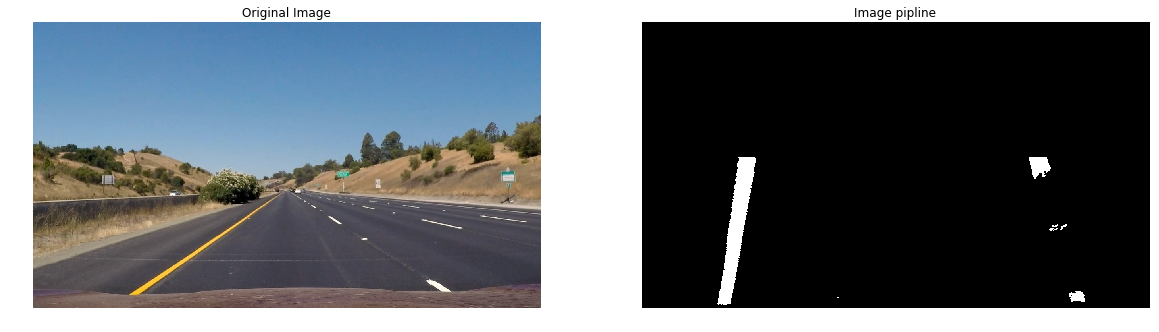

In [11]:
def image_transform_pipline(image):
    undistorted_image = undistort_camera_image(image)
    transform = threshold_transform(undistorted_image)
    roi_image = region_of_interest(transform)
    prespective = prespective_transform(roi_image)
    
    return prespective

def test_transform_pipline():
    test_image = load_test_road_image()
    transform_image = image_transform_pipline(test_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(transform_image.squeeze(), cmap='gray')
    axs[1].set_title("Image pipline")
    axs[1].axis('off')
    
    plt.show()
    
test_transform_pipline()

### Lane finding

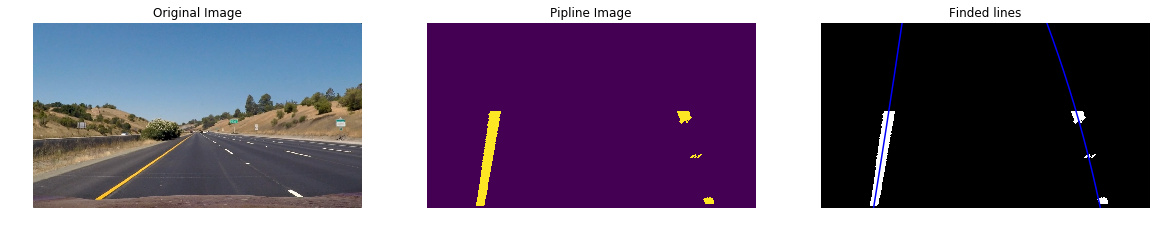

In [12]:
def find_lines(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0)
    
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0] / nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
    
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit


def find_lines_quick(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def get_fitx_and_fity(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def get_left_right_curve(binary_warped, left_fit, right_fit):
    
    left_fitx, right_fitx, ploty = get_fitx_and_fity(binary_warped, left_fit, right_fit)
    
    y_eval = np.max(ploty)
    
    ym_per_pix = 30 / 720 
    xm_per_pix = 3.7 / 700

    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
        
    return (left_curverad + right_curverad) / 2

def get_center_distance(binary_warped, left_fit, right_fit):
    
    xm_per_pix = 3.7 / 700
    
    left_fitx, right_fitx, _ = get_fitx_and_fity(binary_warped, left_fit, right_fit)
    
    position = (np.mean(left_fitx) + np.mean(right_fitx)) / 2
    distance_from_center = abs((640 - position) * xm_per_pix) 
    
    return distance_from_center

def test_find_lines():
    test_image = load_test_road_image()
    binary_warped = image_transform_pipline(test_image)
    left_fit, right_fit= find_lines(binary_warped)
    
    left_fitx, right_fitx, ploty = get_fitx_and_fity(binary_warped, left_fit, right_fit)

    fig, axs = plt.subplots(1, 3, figsize=(20, 30))
    
    axs[0].imshow(test_image.squeeze())
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(binary_warped.squeeze())
    axs[1].set_title("Pipline Image")
    axs[1].axis('off')
    
    axs[2].imshow(binary_warped.squeeze(), cmap='gray')
    axs[2].set_title("Finded lines")
    axs[2].plot(left_fitx, ploty, color='blue')
    axs[2].plot(right_fitx, ploty, color='blue')
    axs[2].set_xlim(0, 1280)
    axs[2].set_ylim(720, 0)
    axs[2].axis('off')
    
    plt.show()
    
test_find_lines()

### Drawing image

Found 8 images!


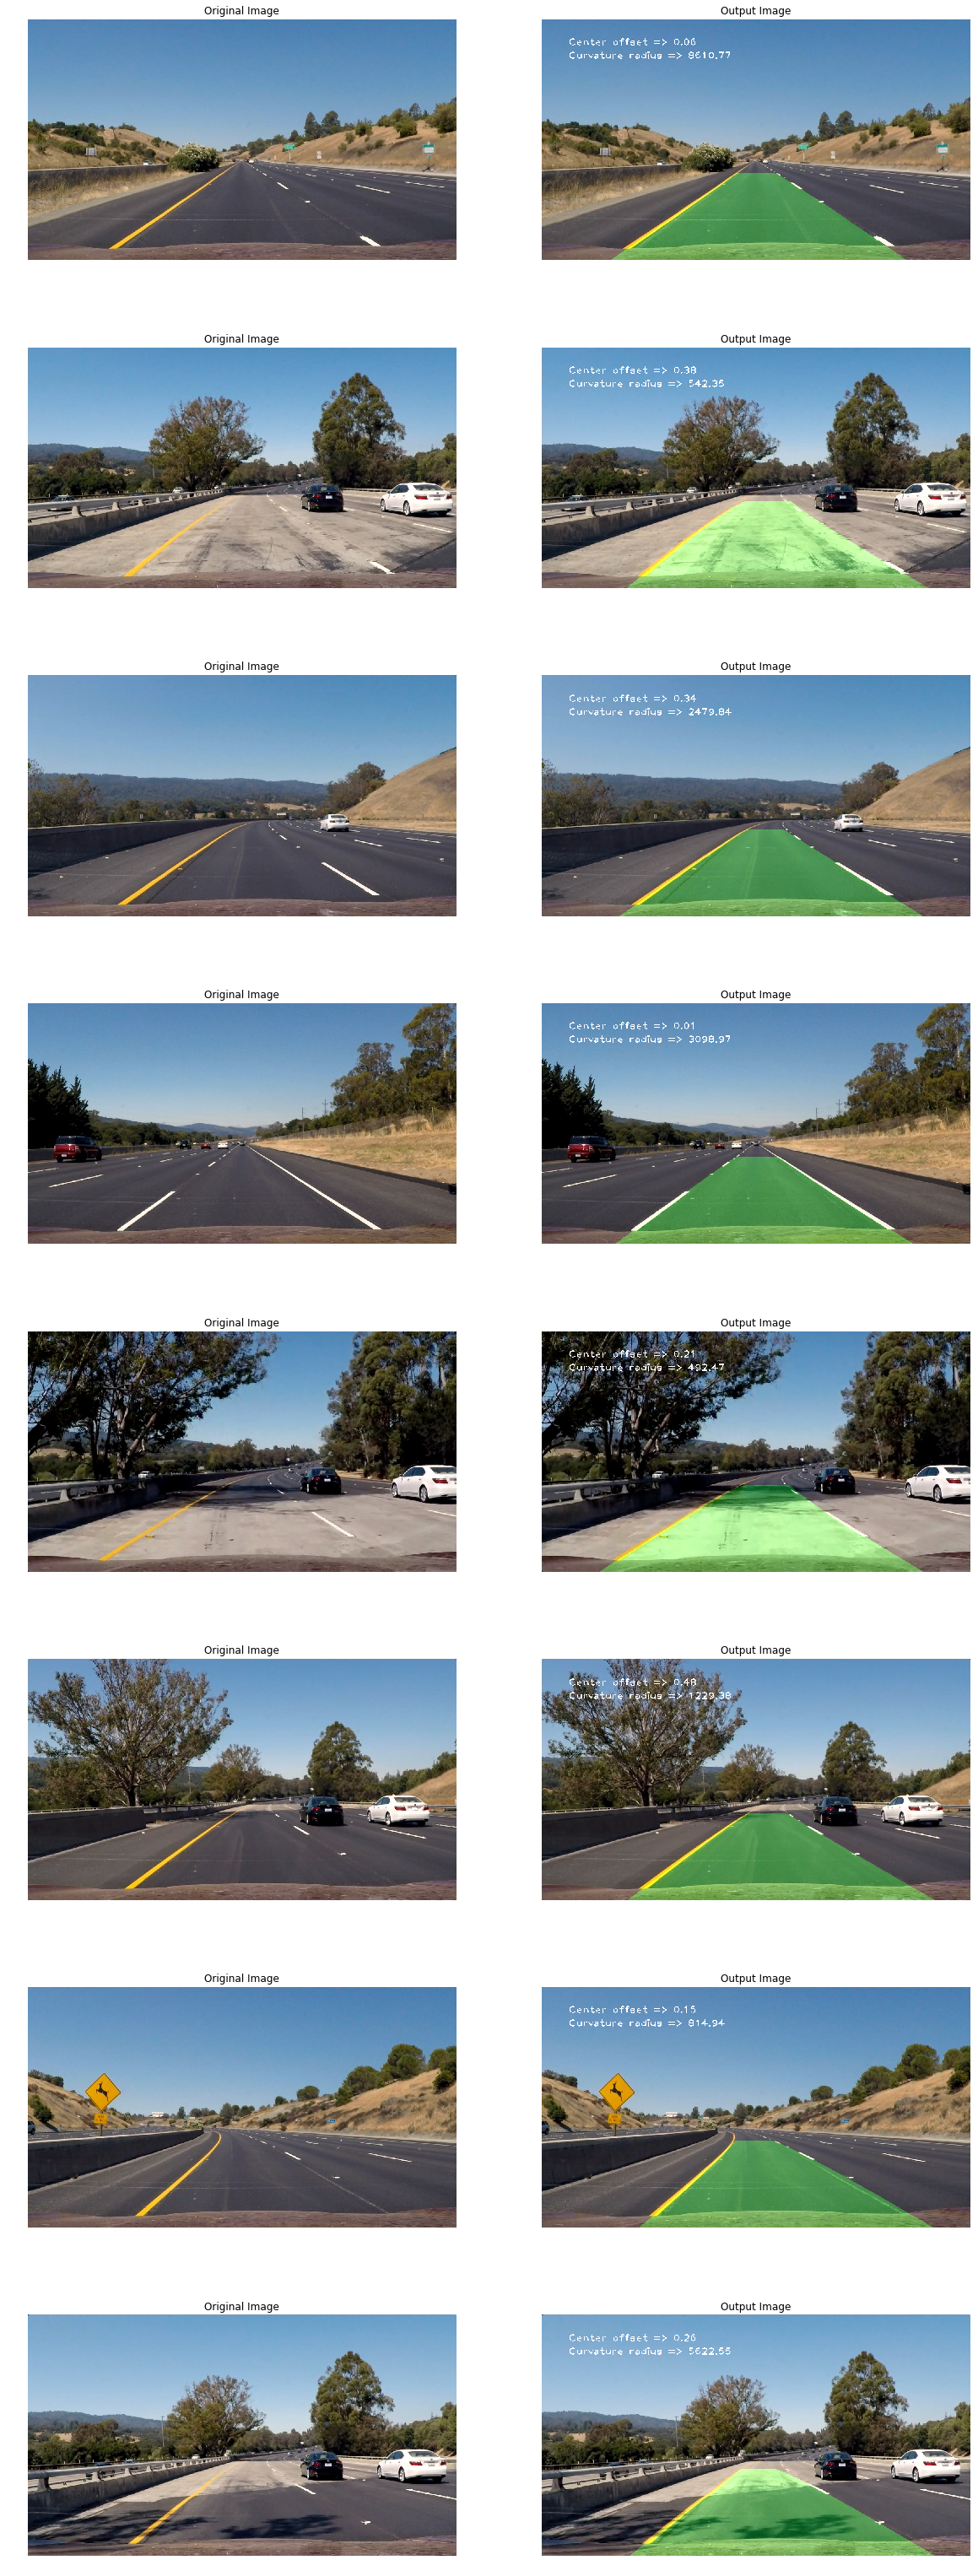

In [13]:
def draw_lines_on_image(image, binary_warped, left_fit, right_fit):
    left_fitx, right_fitx, ploty = get_fitx_and_fity(binary_warped, left_fit, right_fit)

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, reverse_prespective_transform_matrix, (image.shape[1], image.shape[0])) 
    
    return cv2.addWeighted(image, 1, newwarp, 0.3, 0)

def draw_text_on_image(image, text, position=(0, 0)):
    cv2.putText(image, text, position, fontFace=1, fontScale=2, color=(255, 255, 255), thickness=2)
    return image

def image_pipline(image):
    
    binary_warped = image_transform_pipline(image)
    
    left_fit, right_fit= find_lines(binary_warped)
    
    turning_curved = get_left_right_curve(binary_warped, left_fit, right_fit)
    distance_from_center = get_center_distance(binary_warped, left_fit, right_fit)
        
    draw_image = draw_lines_on_image(image, binary_warped, left_fit, right_fit)
    text_image = draw_text_on_image(draw_image, 'Center offset => {:.2f}'.format(distance_from_center), (80, 80))
    text_image = draw_text_on_image(text_image, 'Curvature radius => {:.2f}'.format(turning_curved), (80, 120))

    return text_image
    
def test_image_pipline():
    
    index = 0
    
    for image_address in glob.glob('test_images/*.jpg'):
        index = index + 1

    print("Found {} images!".format(index))
    
    fig, axs = plt.subplots(index, 2, figsize=(20, index * 7))

    for i, image_address in enumerate(glob.glob('test_images/*.jpg')):
        image = load_image_from_address(image_address)
        output = image_pipline(image)
        
        axs[i][0].imshow(image.squeeze())
        axs[i][0].set_title("Original Image")
        axs[i][0].axis('off')
        
        axs[i][1].imshow(output.squeeze())
        axs[i][1].set_title("Output Image")
        axs[i][1].axis('off')
        
        imsave(OUT_PUT_IMAGE_PATTERN.format(i), output.squeeze())
    
    plt.show()

test_image_pipline()

### Video Pipline

In [15]:
def video_pipline(input_video, output_video):
    
    input_clip = VideoFileClip(input_video)

    outout_clip = input_clip.fl_image(image_pipline)
    outout_clip.write_videofile(output_video, audio=False)

    
video_pipline('project_video.mp4', 'output_videos/project_video_lanes.mp4')
# video_pipline('challenge_video.mp4', 'output_videos/challenge_video_lanes.mp4')

[MoviePy] >>>> Building video output_videos/project_video_lanes.mp4
[MoviePy] Writing video output_videos/project_video_lanes.mp4


100%|█████████▉| 1260/1261 [23:13<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_lanes.mp4 

